In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
path = 'data/ml-1m/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train.head()

,userId,movieId,rating
0,4783,109,5
1,4071,482,4
2,3133,433,3
3,3216,983,4
4,886,1126,4


In [4]:
train.shape

(800167, 3)

In [5]:
# drop movies from test that aren't in train
# test = test[test['movieId'].isin(set(train.movieId.unique()))]

In [6]:
n_users = train.userId.nunique()
n_items = train.movieId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 6040
Number of items: 3679


In [7]:
max_users = max(train.userId.max(), test.userId.max())
max_items = max(train.movieId.max(), test.movieId.max())
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 6039
Max movie ID: 3705


## Neural network model

In [8]:
from tensorflow.keras import backend as K

def squeeze(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [9]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 10, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 10, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=squeeze)(d2)

# Create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        37060       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        60400       User-Input[0][0]                 
______________________________________________________________________________________________

Train on 800167 samples
Epoch 1/10
800167/800167 [==============================] - 10s 13us/sample - loss: 0.8840
Epoch 2/10
800167/800167 [==============================] - 11s 14us/sample - loss: 0.8180
Epoch 3/10
800167/800167 [==============================] - 12s 14us/sample - loss: 0.7964
Epoch 4/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7764
Epoch 5/10
800167/800167 [==============================] - 12s 14us/sample - loss: 0.7641
Epoch 6/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7566
Epoch 7/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7496
Epoch 8/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7449
Epoch 9/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7393
Epoch 10/10
800167/800167 [==============================] - 12s 15us/sample - loss: 0.7339


Text(0, 0.5, 'Training Error')

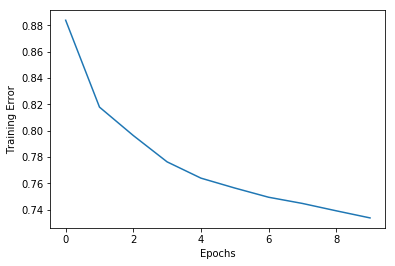

In [10]:
# model = load_model('regression_model2.h5')

history = model.fit([train.userId, train.movieId], train.rating, batch_size=256, epochs=10)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [11]:
model.evaluate([test.userId, test.movieId], test.rating, batch_size=1024)

200042/200042 [==============================] - 0s 2us/sample - loss: 0.7761


0.776074686411877

In [12]:
predictions = model.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.7932658] 4
[4.048266] 4
[3.2481961] 2
[3.5198946] 4
[3.4973135] 4
[3.582641] 3
[3.3273911] 1
[3.9300199] 4
[3.8342562] 4
[3.7239685] 4


[None, None, None, None, None, None, None, None, None, None]

## Predict genres

In [13]:
movies = pd.read_csv(path+'movies.csv')
movies = movies[movies['movieId'].isin(set(train.movieId.unique()))]

In [14]:
movies.head()

,movieId,title,genres
0,40,Toy Story (1995),Animation|Children's|Comedy
1,573,Jumanji (1995),Adventure|Children's|Fantasy
2,1333,Grumpier Old Men (1995),Comedy|Romance
3,450,Waiting to Exhale (1995),Comedy|Drama
4,1334,Father of the Bride Part II (1995),Comedy


In [15]:
genres = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy',
          'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

for g in genres:
    movies[g] = movies.genres.apply(lambda x: int(g in x))
    
movies.drop('genres', axis=1, inplace=True)

In [16]:
movies.Comedy.value_counts()

0    2523
1    1156
Name: Comedy, dtype: int64

In [17]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,40,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,573,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1333,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,450,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1334,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
movies.shape

(3679, 20)

In [25]:
# add fully-connected-layers
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(1, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 10)             37060     
_________________________________________________________________
Flatten-Items (Flatten)      (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0   

W0709 17:05:16.157122 15480 deprecation.py:323] From C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3679 samples
Epoch 1/5
3679/3679 [==============================] - 1s 372us/sample - loss: 0.6321 - accuracy: 0.6858
Epoch 2/5
3679/3679 [==============================] - 1s 296us/sample - loss: 0.6247 - accuracy: 0.6858
Epoch 3/5
3679/3679 [==============================] - 1s 299us/sample - loss: 0.6220 - accuracy: 0.6858
Epoch 4/5
3679/3679 [==============================] - 1s 288us/sample - loss: 0.6206 - accuracy: 0.6858
Epoch 5/5
3679/3679 [==============================] - 1s 294us/sample - loss: 0.6188 - accuracy: 0.6858


Text(0, 0.5, 'Training Error')

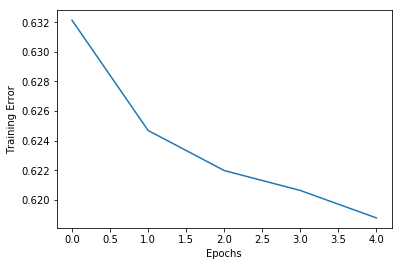

In [26]:
history = model2.fit(movies.movieId, movies.Comedy, batch_size=4, epochs=5)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [27]:
model2.evaluate(movies.movieId, movies.Comedy, batch_size=16)

3679/3679 [==============================] - 0s 64us/sample - loss: 0.6130 - accuracy: 0.6858


[0.6130018709275541, 0.68578416]

In [50]:
np.round(model2.predict(movies.movieId.head(10)))

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

## Visualise embeddings

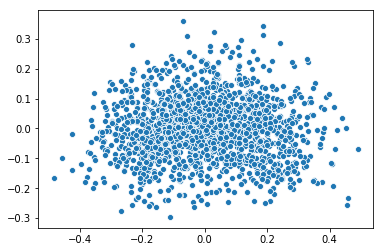

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [15]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0

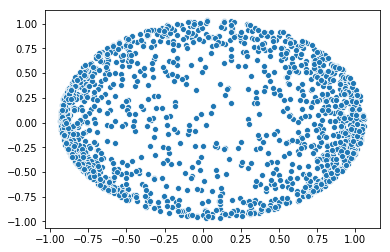

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.187900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.100006
[t-SNE] KL divergence after 300 iterations: 1.150350


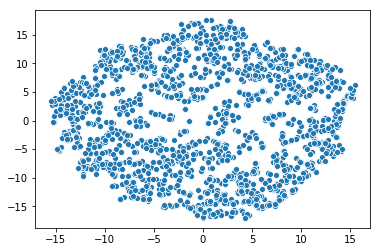

In [18]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [47]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.movieId)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [48]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [49]:
predictions = model2.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([ 167, 2617,   44, 3629,   23], dtype=int64)

In [50]:
# print predicted scores
predictions[recommended_movie_ids]

array([4.7353106, 4.7262664, 4.70117  , 4.695665 , 4.6925473],
      dtype=float32)

In [51]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,40,Toy Story (1995),Animation|Children's|Comedy
1,573,Jumanji (1995),Adventure|Children's|Fantasy
2,1333,Grumpier Old Men (1995),Comedy|Romance
3,450,Waiting to Exhale (1995),Comedy|Drama
4,1334,Father of the Bride Part II (1995),Comedy


In [52]:
movies[movies['movieId'].isin(recommended_movie_ids)]

,movieId,title,genres
253,44,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
309,167,"Shawshank Redemption, The (1994)",Drama
513,23,Schindler's List (1993),Drama|War
2698,2617,Sanjuro (1962),Action|Adventure
3010,3629,Smashing Time (1967),Comedy
